In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('..')
import myd2l

In [9]:
batch_size, num_steps = 32, 35
train_iter, vocab = myd2l.load_data_time_machine(batch_size, num_steps)

In [10]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [11]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [12]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
    
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size) 
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))

        return output, state

    def begin_state(self, batch_size, device):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device)
        else:
            return (
                torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device),
                torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device)
            )
        

In [13]:
device = torch.device('cuda')
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
myd2l.predict('time traveller', 10, net, vocab, device)

'time travellerrbbvlrorbb'

epoch 10, perplexity 11.4
time traveller an an an an an an an an an an an an an an an an a
epoch 20, perplexity 9.3
time travellere the the the the the the the the the the the the 
epoch 30, perplexity 8.4
time traveller and the mere the that in this the that in this th
epoch 40, perplexity 8.0
time traveller and the the that an and the mere the that and the
epoch 50, perplexity 7.3
time traveller the this the thime simens on the the the the the 
epoch 60, perplexity 6.8
time traveller the thine dimensions and there in the thate the t
epoch 70, perplexity 6.5
time traveller and thry in this beat ano the the thisg the gidit
epoch 80, perplexity 5.5
time traveller that is the wist another dimensions and the at in
epoch 90, perplexity 4.6
time traveller thice and there wis thise dimension thed the prom
epoch 100, perplexity 3.8
time travellery and the thane thay send sind aid as shallatlly r
epoch 110, perplexity 3.2
time travellerit sou and the tore troved the meding st eal othe 
epoch 1

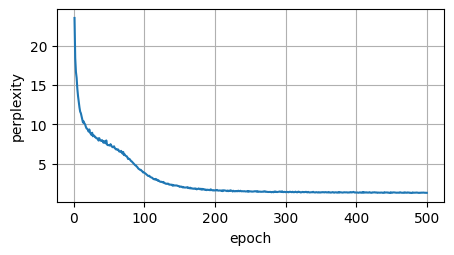

perplexity 1.3, 300830.6 examples/sec on cuda
time traveller of crest hise and why cantanked mathof orithe sor
traveller aus chanl dow a sovisthes thin the gote brover st


In [14]:
num_epochs, lr = 500, 1
myd2l.train_lm(net, train_iter, vocab, lr, num_epochs, device)